In [1]:
from tensorflow import keras
from numpy import dstack
from keras.models import load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
 

In [2]:
path = "pamap_scaled.h5"

In [3]:
f = h5py.File(path, 'r')
X = f.get('inputs')
y = f.get('labels') 
#print(type(X))
#print(type(y))
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)
X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, test_size=0.3, random_state = 1)

In [4]:
trainy_one_hot = to_categorical(y_train)
valy_one_hot = to_categorical(y_val)
testy_one_hot = to_categorical(y_test)


In [5]:
n_steps, n_length, n_features = 4, 32, 39

In [6]:
X_train3 = X_train.reshape((X_train.shape[0], n_steps, n_length,n_features))

## Loading Models:

- **model1: 3levels on CNN (4layers in each)(takes 4input)**

In [7]:
model1 = load_model("Models_h5//model1.h5")

- **model2: 3levels on CNN (4layers in each) , parallaly 1LSTM layer (takes 5inputs)**

In [8]:
model2 = load_model("Models_h5//model2.h5")

- **model3: Timdistributed ConvLSTM(takes 1input)**

In [9]:
model3 = load_model("Models_h5//model3.h5")

- **model4: 2layered LSTM(takes 1input)**

In [10]:
model4 = load_model("Models_h5//model4.h5")

##  Running the member models to make predictions on the validation set, and create a new training set with the resulting predictions

In [11]:
n_steps, n_length, n_features = 4, 32, 39
X_val3 = X_val.reshape((X_val.shape[0], n_steps, n_length,n_features))

In [12]:
stackX = None

In [13]:
##Output model1
yhat = model1.predict([X_val,X_val,X_val,X_val], verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX =yhat

In [14]:
##Output model2
yhat = model2.predict([X_val,X_val,X_val,X_val,X_val], verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX = dstack((stackX, yhat))

In [15]:
##Output model3

yhat = model3.predict(X_val3, verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX = dstack((stackX, yhat))

In [16]:
##Output model4
yhat = model4.predict(X_val, verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX = dstack((stackX, yhat))

In [17]:
stackX.shape

(1, 2063, 4)

In [18]:
stackX = stackX.reshape((stackX.shape[0]*stackX.shape[1],stackX.shape[2]))

In [19]:
stackX.shape####it is the training set of the ensembling classifier

(2063, 4)

In [20]:
y_val.shape

(2063,)

In [21]:
from sklearn.ensemble import RandomForestClassifier
EnsemHAR=RandomForestClassifier(n_estimators= 2000,
 min_samples_split= 9,
 min_samples_leaf= 2,
 max_features='sqrt',
 max_depth= 340,
 criterion= 'gini')


In [22]:
y_val_1D=np.ravel(y_val)

In [23]:
EnsemHAR.fit(stackX,y_val_1D)

RandomForestClassifier(max_depth=340, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=9, n_estimators=2000)

##  Now evaluate the ensemble on the test set:
#### Create stacked model input dataset as outputs from the ensemble;

In [24]:
stackX = None

In [25]:
n_steps, n_length, n_features = 4, 32, 39
X_test3 = X_test.reshape((X_test.shape[0], n_steps, n_length,n_features))

In [26]:
##Output model1
yhat = model1.predict([X_test,X_test,X_test,X_test], verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX = yhat

In [27]:
##Output model2
yhat = model2.predict([X_test,X_test,X_test,X_test,X_test], verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX = dstack((stackX, yhat))

In [28]:
##Output model3

yhat = model3.predict(X_test3, verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX = dstack((stackX, yhat))

In [29]:
##Output model4
yhat = model4.predict(X_test, verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX = dstack((stackX, yhat))

In [30]:
stackX.shape

(1, 2946, 4)

In [31]:
stackX = stackX.reshape((stackX.shape[0]*stackX.shape[1],stackX.shape[2]))

In [32]:
stackX.shape

(2946, 4)

In [33]:
predy=EnsemHAR.predict(stackX)


In [34]:
import seaborn as sns
import sklearn.metrics as skm
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix,classification_report
cm=confusion_matrix(y_test,predy)
print(cm)
print(acc(y_test,predy))
print(classification_report(y_test,predy))

[[ 56   0   0   0   0   0   0   0   0   0   0   0]
 [  1 270   1   0   0   0   0   0   1   0   1   0]
 [  0   0 273   4   0   0   0   0   0   0   2   0]
 [  0   0   1 300   0   0   0   0   0   0   1  12]
 [  0   0   0   0 340   0   0   2   5   1   0   0]
 [  2   1   0   0   0 147   0   2   0   0   0   0]
 [  0   0   0   0   1   0 261   0   0   0   0   0]
 [  0   0   0   0   0   0   0 286   0   0   0   0]
 [  0   0   0   0   0   0   0   0 187   6   3   0]
 [  0   0   2   0   0   0   0   0   8 151   1   0]
 [  0   0   0   1   0   0   0   0   0   1 240   2]
 [  0   0   0   5   0   0   0   0   0   0   1 367]]
0.9769178547182621
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        56
           1       1.00      0.99      0.99       274
           2       0.99      0.98      0.98       279
           3       0.97      0.96      0.96       314
           4       1.00      0.98      0.99       348
           5       1.00      0.97      0.98

In [85]:
cf=np.empty((12,12))
for i in range(12):
    cf[i]=(cm[i]/np.sum(cm[i]))

In [86]:
# group_counts = ["{0:.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()]
labels = [f"{v1}" for v1 in group_percentages]
labels = np.asarray(labels).reshape(12,12)

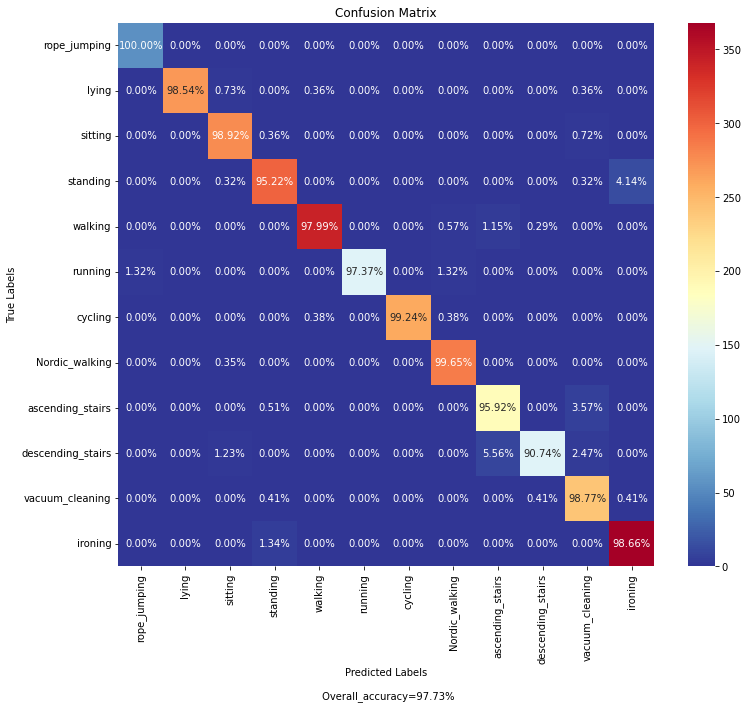

In [88]:
fig = plt.figure(figsize=(12,10))
ax=fig.add_subplot(111)
sns.heatmap(cm, annot=labels,fmt="",cmap='RdYlBu_r',ax=ax)
ax.set_xlabel("Predicted Labels\n\n Overall_accuracy=""{0:.2%}".format(acc(y_test,predy)))
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(['rope_jumping','lying','sitting','standing','walking','running','cycling','Nordic_walking','ascending_stairs','descending_stairs','vacuum_cleaning','ironing'],rotation=90)
ax.yaxis.set_ticklabels(['rope_jumping','lying','sitting','standing','walking','running','cycling','Nordic_walking','ascending_stairs','descending_stairs','vacuum_cleaning','ironing'],rotation=360)
plt.savefig("Metrics//CM_PAMAP2",dpi=1200, bbox_inches='tight')

In [89]:
##ROC curve plot
from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}

roc_auc={}

class_number = 12
predy_one_hot=to_categorical(predy)

In [90]:
for i in range(class_number):    
    fpr[i], tpr[i], _ = roc_curve(y_test, predy_one_hot[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [91]:
all_fpr=np.unique(np.concatenate([fpr[i] for i in range(class_number)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(class_number):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= class_number

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

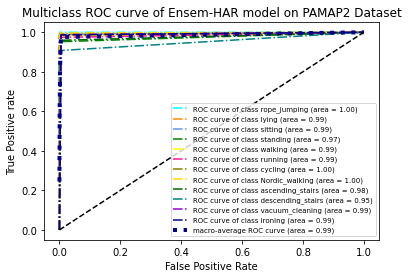

In [92]:
from itertools import cycle
colors = cycle(["aqua", "darkorange", "cornflowerblue","green","yellow","deeppink",'olive',"gold","darkgreen","teal","darkviolet","navy"])
n_classes=['rope_jumping','lying','sitting','standing','walking','running','cycling','Nordic_walking','ascending_stairs','descending_stairs','vacuum_cleaning','ironing']
for i,cls, color in zip(range(class_number),n_classes, colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        linestyle='-.',
        label="ROC curve of class {0} (area = {1:0.2f})".format(cls, roc_auc[i]),
    )
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)
plt.plot([0, 1], [0, 1], "k--")
plt.title('Multiclass ROC curve of Ensem-HAR model on PAMAP2 Dataset')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc="lower right",prop={"size":7})

plt.savefig('Metrics//Multiclass_ROC_PAMAP2',dpi=1200, bbox_inches='tight')    



In [93]:
predy_m1=model1.predict([X_test,X_test,X_test,X_test])
predy_m1=np.argmax(predy_m1, axis=-1)
predy_m2=model2.predict([X_test,X_test,X_test,X_test,X_test])
predy_m2=np.argmax(predy_m2, axis=-1)
predy_m3=model3.predict(X_test3)
predy_m3=np.argmax(predy_m3, axis=-1)
predy_m4=model4.predict(X_test)
predy_m4=np.argmax(predy_m4, axis=-1)
predy_en=EnsemHAR.predict(stackX)

In [94]:
#all models predictions
model_pred=[predy_m1,predy_m2,predy_m3,predy_m4,predy_en]

In [95]:
model_acc={}
models=['CNN-net','CNN_LSTM-net','ConvLSTM-net','Stacked_LSTM-net','Ensem-HAR']
i=0
for pred,model in zip(model_pred,models):
    model_acc[model]=acc(y_test,pred)*100

In [99]:
model_acc

{'CNN-net': 97.01289884589274,
 'CNN_LSTM-net': 96.91289084080265,
 'ConvLSTM-net': 96.87712152070604,
 'Stacked_LSTM-net': 95.96062457569586,
 'Ensem-HAR': 97.72572980312287}

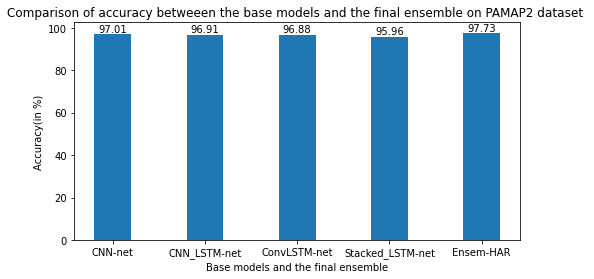

In [100]:
fig = plt.figure(figsize=(8,4))
plt.bar(model_acc.keys(),model_acc.values(),width=0.4)
y=list(model_acc.values())
plt.xlabel("Base models and the final ensemble")
plt.ylabel("Accuracy(in %)")
plt.title("Comparison of accuracy betweeen the base models and the final ensemble on PAMAP2 dataset ")
for i in range(5):
    plt.text(i,y[i],"{0:0.2f}".format(y[i]),ha="center",va="bottom")
plt.savefig('Metrics//accuracy_comparison',dpi=1200, bbox_inches='tight')   

In [61]:
pre=np.empty((0,12))
re=np.empty((0,12))
f1_=np.empty((0,12))
for predy in model_pred:
    precision=skm.precision_score(y_test, predy, average=None)
    pre=np.vstack([pre,precision])
    recall=skm.recall_score(y_test, predy, average=None)
    re=np.vstack([re,recall])
    f1=skm.f1_score(y_test, predy, average=None)
    f1_=np.vstack([f1_,f1])

In [63]:
df_pre=pd.DataFrame(pre)
df_pre.columns=['rope_jumping','lying','sitting','standing','walking','running','cycling','Nordic_walking','ascending_stairs','descending_stairs','vacuum_cleaning','ironing']
df_pre.index=['CNN-net','CNN_LSTM-net','ConvLSTM-net','Stacked_LSTM-net','Ensemble_HAR']
df_re=pd.DataFrame(re)
df_re.columns=['rope_jumping','lying','sitting','standing','walking','running','cycling','Nordic_walking','ascending_stairs','descending_stairs','vacuum_cleaning','ironing']
df_re.index=['CNN-net','CNN_LSTM-net','ConvLSTM-net','Stacked_LSTM-net','Ensemble_HAR']
df_f1=pd.DataFrame(f1_)
df_f1.columns=['rope_jumping','lying','sitting','standing','walking','running','cycling','Nordic_walking','ascending_stairs','descending_stairs','vacuum_cleaning','ironing']
df_f1.index=['CNN-net','CNN_LSTM-net','ConvLSTM-net','Stacked_LSTM-net','Ensemble_HAR']

In [64]:
df_pre.to_csv('Precision.csv')
df_re.to_csv('Recall.csv')
df_f1.to_csv('f1_score.csv')

In [35]:
sample_X=[]
sample_y=[]

In [36]:
#creating 10 sample dataset of size 50 from the test data
for i in range(10):
    demo_X=np.empty((50,128,39))
    demo_y=np.empty(50)
    demo_X=X_test[(i*200):(i*200)+50]#each sample
    demo_y=y_test[(i*200):(i*200)+50]
    sample_X.append(demo_X)# appending to the list of samples
    sample_y.append(demo_y)


In [37]:
len(sample_X)

10

In [38]:
# accuracy of each base models and ensemble on 10 sample dataset of size 50 taken from the test data
m1_acc=[]
m2_acc=[]
m3_acc=[]
m4_acc=[]
ensem_acc=[]

for sample,y_testSample in zip(sample_X,sample_y):
    stackSamp=None
    predy_m1=model1.predict([sample,sample,sample,sample])
    predy_m1=np.argmax(predy_m1, axis=-1)
    m1_acc.append(acc(predy_m1,y_testSample))

    stackSamp=predy_m1
    
    predy_m2=model2.predict([sample,sample,sample,sample,sample])
    predy_m2=np.argmax(predy_m2, axis=-1)
    m2_acc.append(acc(predy_m2,y_testSample))

    stackSamp=dstack((predy_m2,stackSamp))
    
    sample3 = sample.reshape((sample.shape[0], n_steps, n_length,n_features))
    predy_m3=model3.predict(sample3)
    predy_m3=np.argmax(predy_m3, axis=-1)
    m3_acc.append(acc(predy_m3,y_testSample))

    stackSamp=dstack((predy_m3,stackSamp))
    
    predy_m4=model4.predict(sample)
    predy_m4=np.argmax(predy_m4, axis=-1)
    m4_acc.append(acc(predy_m4,y_testSample))

    stackSamp=dstack((predy_m4,stackSamp))
    
    stackSamp = stackSamp.reshape((stackSamp.shape[0]*stackSamp.shape[1],stackSamp.shape[2]))
    predy_en=EnsemHAR.predict(stackSamp)
    ensem_acc.append(acc(predy_en,y_testSample))

In [39]:
ranking=pd.DataFrame()
ranking['CNN-net']=m1_acc
ranking['CNN_LSTM-net']=m2_acc
ranking['ConvLSTM-net']=m3_acc
ranking['Stacked_LSTM-net']=m4_acc
ranking['Ensem-HAR']=ensem_acc

In [41]:
ranking.to_csv('accuracies.csv')